# Introduction

Cross-border trade and investment are becoming ever more important for future economic prosperity.  For the United States and Canada, where culture; language, and legal frameworks are extremely similar; a significant amount of normal barriers to trade are non-existent due to these factors.  Without these barriers, entrepreneurs from either country looking to invest in the other can place greater resources on identifying profitable opportunities rather than overcoming trade barriers.

The goal of the project was to generate useful analytical information for entrepreneurs to identify profitable investment opportunities in Toronto and New York.  The project aimed to identify the most popular venues in the two cities, and if significant overlap existed in the types of venues that are popular in both places.  By identifying these information, the project could assist entrepreneurs to identify business opportunities to invest in these cities, as well as providing insight on whether the target of their investment are profitable or not.

# Data Used

The data used in the project came from four sources: the University of New York, the City of Toronto, and Foursquare.  The data from these sources were used to obtain the lists of neighborhoods in the cities of Toronto and New York, as well as to obtain the coordinates of neighborhoods, trending venues, and plotting important information on interactive maps.  

The data on neighborhoods and GIS coordinatees of these neighborhoods are provided by the City of Toronto and New York University respectively.  The data lists all neighborhood as defined by the cities' surveying authoriites, and their GIS coordinates.

The data on trending venues in each of the cities is provided by Foursquare API.  The cooridinates of each neighborhood is passed through the API to obtain the most trending venues in each neighborhood.  With this data, statistical analysis can be conducted on the popularity of different types of venues in each city and therefore what investment opportunities exist.

# Analytical Methods

To identify business insights that are useful for entrepreneurs, both traditional statistics techniques as well as machine learning algorithms were employed in the analysis.  The traditional statistics techniques, such as summary statistics on the number and type of venues, were used to obtain high-level insights such as the type of popular venues and characteristics of neighborhoods.  Machine learning algorithms were also employed to group neighborhoods in Toronto and New York with similar characteristics together to identify neighborhoods with similar characteristics and therefore potential opportunities for investors to open similar venues.

To identify the higher level similarities, summary statistics were used to identify the most popular venues in both cities.  Techniques used include ranking venues by their frequency in both on the municipal level as well as on borough and neighborhood levels.  For example, by comparing the frequency of cafes in the two cities, it was possible to determine if cafes were popular and therefore provided good investment opportunities in both cities.  More broadly, the information could used to identify the general areas that are favorable for investors.

For more in depths analysis on the neighborhood level, clustering algorithms were used to cluster neighborhoods with similar characteristics together.  Two machine learning algorithms, K-Means clustering and DBSCAN clustering, were used.  By identifying neighborhoods that share the most common characteristics, entrepreneurs that are successful in one neighborhood can identify similar business opportunities in other neighborhoods.  For instance, if the boroughs of Downtown Toronto and Manhattan could be clustered together, the information were further analyzed to determine if investment opportunities exist that can leverage the similarities of both boroughs.

Finally, Folium is used to plot any data that require interactive map visualization.  This includes the location of neighborhood clusters, the location of venues, and other major thoroughfares.

# Code

## Statistical Analysis

### Import the libraries

In [1]:
#install conda packages if they have not been run
#!conda install -c conda-forge lxml
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.5.0 --yes

In [16]:
import pandas as pd
import numpy as np
import folium

#import geocoder libraries
from geopy.geocoders import Nominatim
from IPython.display import Image
from IPython.core.display import HTML

#import .json libraries
import json
from pandas.io.json import json_normalize
import requests

#import visualization libraries
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import machine learning libraries
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [21]:
#Foursquared Credentials
CLIENT_ID = 'FQBYT13ZD21NGVPZ22FXVVEKOEZBLBT02KJC0D1R4HT10SKH'
CLIENT_SECRET = 'PMDHKUUT5C32UJKBQLKWT5EX50SKCT2LBO5DVJZ240SSTRGK'
VERSION = '20180604'
radius = 500
LIMIT = 100

In [3]:
#Toronto and New York Coordinates
torLat = 43.6532
torLong = -79.3832

nyLat = 40.7128
nyLong = -74.060

### Import the datasets

Please note that the raw datasets extracted from the .json file and online source for the neighborhoods in Toronto and Manhattan have previously been cleaned to remove rows  with NULLs.

In [4]:
#import the datasets
df_newyork = pd.read_csv('https://raw.githubusercontent.com/andrew940524/IBM/master/new%20york%20neighborhoods.csv')
df_toronto = pd.read_csv('https://raw.githubusercontent.com/andrew940524/IBM/master/Toronto_Neighborhoods.csv')
df_newyork

,Unnamed: 0,Borough,Neighborhood,Latitude,Longitude
0,0,Bronx,Wakefield,40.894705,-73.847201
1,1,Bronx,Co-op City,40.874294,-73.829939
2,2,Bronx,Eastchester,40.887556,-73.827806
3,3,Bronx,Fieldston,40.895437,-73.905643
4,4,Bronx,Riverdale,40.890834,-73.912585
...,...,...,...,...,...
301,301,Manhattan,Hudson Yards,40.756658,-74.000111
302,302,Queens,Hammels,40.587338,-73.805530
303,303,Queens,Bayswater,40.611322,-73.765968
304,304,Queens,Queensbridge,40.756091,-73.945631


In [5]:
df_toronto.columns

Index(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
       'AREA_LONG_CODE', 'AREA_NAME', 'AREA_DESC', 'X', 'Y', 'LONGITUDE',
       'LATITUDE', 'OBJECTID', 'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [6]:
#clean the datasets to get rid of the unwanted data
df_newyork.drop(['Unnamed: 0', 'Borough'], axis=1, inplace=True)
df_toronto.drop(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
       'AREA_LONG_CODE', 'AREA_DESC', 'X', 'Y', 'OBJECTID', 'Shape__Area', 'Shape__Length', 'geometry'], axis=1, inplace=True)

In [7]:
df_toronto.rename(columns={'AREA_NAME':'Neighborhood','LONGITUDE':'Longitude','LATITUDE':'Latitude'}, inplace=True)
df_toronto

,Neighborhood,Longitude,Latitude
0,Wychwood (94),-79.425515,43.676919
1,Yonge-Eglinton (100),-79.403590,43.704689
2,Yonge-St.Clair (97),-79.397871,43.687859
3,York University Heights (27),-79.488883,43.765736
4,Yorkdale-Glen Park (31),-79.457108,43.714672
...,...,...,...
135,Kennedy Park (124),-79.260382,43.725556
136,Kensington-Chinatown (78),-79.397240,43.653554
137,Kingsview Village-The Westway (6),-79.547863,43.698993
138,Kingsway South (15),-79.510577,43.653520


### Neighborhood Analysis

In [8]:
df_newyork.shape

(306, 3)

In [9]:
df_toronto.shape

(140, 3)

In [10]:
#define the function that extracts the venue type
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
#create the function that extracts the most trendy venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Wychwood (94)
Yonge-Eglinton (100)
Yonge-St.Clair (97)
York University Heights (27)
Yorkdale-Glen Park (31)
Lambton Baby Point (114)
Lansing-Westgate (38)
Lawrence Park North (105)
Lawrence Park South (103)
Leaside-Bennington (56)
Little Portugal (84)
Long Branch (19)
Malvern (132)
Maple Leaf (29)
Markland Wood (12)
Milliken (130)
Mimico (includes Humber Bay Shores) (17)
Morningside (135)
Moss Park (73)
Mount Dennis (115)
Mount Olive-Silverstone-Jamestown (2)
Mount Pleasant East (99)
Mount Pleasant West (104)
New Toronto (18)
Newtonbrook East (50)
Newtonbrook West (36)
Niagara (82)
North Riverdale (68)
North St.James Town (74)
O'Connor-Parkview (54)
Oakridge (121)
Oakwood Village (107)
Old East York (58)
Palmerston-Little Italy (80)
Parkwoods-Donalda (45)
Pelmo Park-Humberlea (23)
Playter Estates-Danforth (67)
Pleasant View (46)
Princess-Rosethorn (10)
Regent Park (72)
Rexdale-Kipling (4)
Rockcliffe-Smythe (111)
Roncesvalles (86)
Rosedale-Moore Park (98)
Rouge (131)
Runnymede-Bloor Wes

In [22]:
newyork_venues = getNearbyVenues(names=df_newyork['Neighborhood'],
                                   latitudes=df_newyork['Latitude'],
                                   longitudes=df_newyork['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Identify the summary of the venues in each city

In [18]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wychwood (94),43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space
1,Wychwood (94),43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market
2,Wychwood (94),43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
3,Wychwood (94),43.676919,-79.425515,Annabelle Pasta Bar,43.675445,-79.423341,Italian Restaurant
4,Wychwood (94),43.676919,-79.425515,Bob Coffee Bar,43.675376,-79.423268,Coffee Shop
...,...,...,...,...,...,...,...
2047,L'Amoreaux (117),43.795716,-79.314084,Coffee Time,43.797952,-79.318678,Coffee Shop
2048,L'Amoreaux (117),43.795716,-79.314084,Super Taste Noodle House,43.798217,-79.318513,Noodle House
2049,L'Amoreaux (117),43.795716,-79.314084,A Buck or Two,43.798286,-79.318485,Thrift / Vintage Store
2050,L'Amoreaux (117),43.795716,-79.314084,Olympian Swimming,43.791575,-79.313204,Gym Pool


In [23]:
newyork_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
9785,Queensbridge,40.756091,-73.945631,Track 114,40.753008,-73.947833,Platform
9786,Fox Hills,40.617311,-74.081740,SUBWAY,40.618939,-74.082881,Sandwich Place
9787,Fox Hills,40.617311,-74.081740,MTA Bus - Vanderbilt Av & Osgood Av (S76),40.617809,-74.081111,Bus Stop
9788,Fox Hills,40.617311,-74.081740,MTA Bus - Targee St & Vanderbilt Av (S74/S76),40.614856,-74.084598,Bus Stop


In [114]:
frames = (newyork_venues, toronto_venues)
neighborhood_venues = pd.concat(frames)
neighborhood_venues.sort_values('Neighborhood').reset_index(drop=True, inplace=True)
neighborhood_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
2047,L'Amoreaux (117),43.795716,-79.314084,Coffee Time,43.797952,-79.318678,Coffee Shop
2048,L'Amoreaux (117),43.795716,-79.314084,Super Taste Noodle House,43.798217,-79.318513,Noodle House
2049,L'Amoreaux (117),43.795716,-79.314084,A Buck or Two,43.798286,-79.318485,Thrift / Vintage Store
2050,L'Amoreaux (117),43.795716,-79.314084,Olympian Swimming,43.791575,-79.313204,Gym Pool


In [415]:
newyork_summary = newyork_venues.groupby('Venue Category').count()[['Venue']]
toronto_summary = toronto_venues.groupby('Venue Category').count()[['Venue']]

In [395]:
#newyork_summary.reset_index(inplace=True)
#toronto_summary.reset_index(inplace=True)

In [416]:
#find the total number of venues
totalTorontoVenue = toronto_summary['Venue'].sum()
totalNewyorkVenue = newyork_summary['Venue'].sum()

In [417]:
#define function that finds the top 20 most numerous venues in the cities
def findTop(dataframe):
    dataframe.sort_values(by='Venue', ascending=False, inplace=True)
    return dataframe.head(20)

In [418]:
torTop = findTop(dataframe = toronto_summary)
nyTop = findTop(dataframe = newyork_summary)

In [419]:
#top venues in Toronto
torTop['Percentage'] = toronto_summary['Venue']/totalTorontoVenue
nyTop['Percentage'] = newyork_summary['Venue']/totalNewyorkVenue

C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [446]:
#torTop.reset_index(drop=True, inplace=True)
torTop

,Venue,Percentage
Venue Category,,
Coffee Shop,155,0.075536
Park,85,0.041423
Café,83,0.040448
Pizza Place,76,0.037037
Sandwich Place,61,0.029727
Italian Restaurant,57,0.027778
Restaurant,52,0.025341
Grocery Store,45,0.021930
Bar,42,0.020468


In [447]:
# top venues in New York
nyTop

,Venue,Percentage
Venue Category,,
Pizza Place,443,0.045250
Italian Restaurant,298,0.030439
Coffee Shop,291,0.029724
Deli / Bodega,268,0.027375
Bakery,216,0.022063
Bar,203,0.020735
Chinese Restaurant,202,0.020633
Grocery Store,196,0.020020
Sandwich Place,183,0.018693


In [453]:
overlap = torTop.merge(nyTop, left_index=True, right_index=True)
overlap = overlap.rename(columns={'key_0':'Venue Category', 
                          'Venue_x':'Toronto Venues', 
                          'Percentage_x':'Toronto Percentages', 
                          'Venue_y':'New York Venues', 
                          'Percentage_y':'New York Percentages'})
overlap['Venue Total'] = overlap['Toronto Venues'] + overlap['New York Venues']
overlap

,Toronto Venues,Toronto Percentages,New York Venues,New York Percentages,Venue Total
Venue Category,,,,,
Coffee Shop,155,0.075536,291,0.029724,446
Park,85,0.041423,177,0.018080,262
Café,83,0.040448,165,0.016854,248
Pizza Place,76,0.037037,443,0.045250,519
Sandwich Place,61,0.029727,183,0.018693,244
Italian Restaurant,57,0.027778,298,0.030439,355
Grocery Store,45,0.021930,196,0.020020,241
Bar,42,0.020468,203,0.020735,245
Bakery,38,0.018519,216,0.022063,254


<Figure size 2880x720 with 0 Axes>

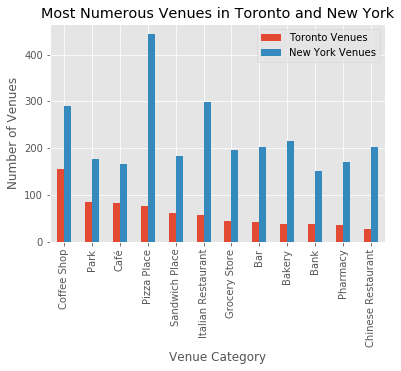

<Figure size 3600x720 with 0 Axes>

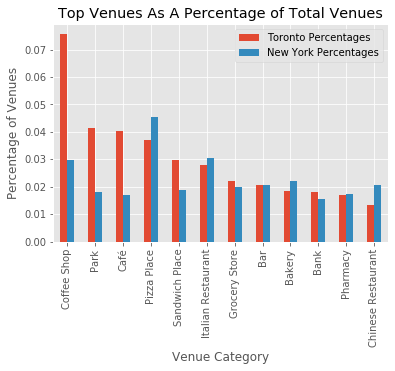

In [450]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(50,10))

ax = overlap[['Toronto Percentages', 'New York Percentages']].plot(kind='bar')

plt.title('Top Venues As A Percentage of Total Venues')
plt.xlabel('Venue Category')
plt.ylabel('Percentage of Venues')
ax.set_xticklabels(overlap.index)

plt.legend()
plt.show()

<Figure size 3600x720 with 0 Axes>

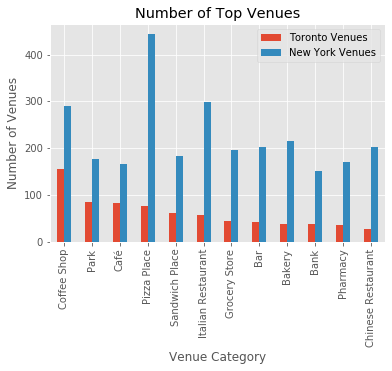

In [451]:
fig = plt.figure(figsize=(50,10))

ax = overlap[['Toronto Venues', 'New York Venues']].plot(kind='bar')

plt.title('Number of Top Venues')
plt.xlabel('Venue Category')
plt.ylabel('Number of Venues')
ax.set_xticklabels(overlap.index)

plt.legend()
plt.show()

#### Identify the top venues in each neighborhood

In [29]:
#onehot encode the cities to get the venues
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#add the neighborhood columns back into the onehot encoded dataframes
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood']
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

In [113]:
newyork_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
9785,Queensbridge,40.756091,-73.945631,Track 114,40.753008,-73.947833,Platform
9786,Fox Hills,40.617311,-74.081740,SUBWAY,40.618939,-74.082881,Sandwich Place
9787,Fox Hills,40.617311,-74.081740,MTA Bus - Vanderbilt Av & Osgood Av (S76),40.617809,-74.081111,Bus Stop
9788,Fox Hills,40.617311,-74.081740,MTA Bus - Targee St & Vanderbilt Av (S74/S76),40.614856,-74.084598,Bus Stop


In [30]:
#Calculate the frequencies of venues in each neighborhood in Toronto and New York
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [31]:
newyork_grouped.shape

(299, 426)

In [32]:
toronto_grouped.shape

(138, 281)

In [99]:
frames = (newyork_grouped, toronto_grouped)
neighborhood_grouped = pd.concat(frames)
neighborhood_grouped.reset_index(drop=True, inplace=True)
neighborhood_grouped = neighborhood_grouped.fillna(0)
neighborhood_grouped.sort_values('Neighborhood')
neighborhood_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Poutine Place,Rock Climbing Spot,Science Museum,Shopping Plaza,Syrian Restaurant,Tram Station,Transportation Service,Tree,Zoo,Zoo Exhibit
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,Wychwood (94),0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,Yonge-Eglinton (100),0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,Yonge-St.Clair (97),0.0,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,York University Heights (27),0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#Sort the venues in descenind order
num_top_venues = 10

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
return_most_common_venues(newyork_grouped.iloc[0, :], num_top_venues)

NameError: name 'num_top_venues' is not defined

In [39]:
num_top_venues = 10
columns = ['Neighborhood']

indicators = ['st', 'nd', 'rd']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
ny_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ny_neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    ny_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

In [40]:
ny_neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Bus Station,Cosmetics Shop,Chinese Restaurant,Supermarket,Department Store,American Restaurant,Dessert Shop,Gas Station
1,Annadale,Pizza Place,Restaurant,Bakery,Pharmacy,Liquor Store,Sports Bar,Diner,Train Station,American Restaurant,Dance Studio
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Home Service,Pizza Place,Yoga Studio,Field,Event Space,Exhibit
3,Arlington,Bus Stop,Intersection,Deli / Bodega,Grocery Store,Coffee Shop,Yoga Studio,Field,Event Space,Exhibit,Eye Doctor
4,Arrochar,Bus Stop,Bagel Shop,Deli / Bodega,Italian Restaurant,Supermarket,Taco Place,Middle Eastern Restaurant,Liquor Store,Outdoors & Recreation,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...
294,Woodhaven,Deli / Bodega,Pharmacy,Bank,Video Store,Pizza Place,Latin American Restaurant,Donut Shop,Dive Bar,Hookah Bar,Restaurant
295,Woodlawn,Pizza Place,Pub,Playground,Deli / Bodega,Food Truck,Grocery Store,Park,Liquor Store,Bakery,Trail
296,Woodrow,Pharmacy,Chinese Restaurant,Miscellaneous Shop,Liquor Store,Grocery Store,Bakery,Sushi Restaurant,Donut Shop,Pizza Place,Bank
297,Woodside,Grocery Store,Latin American Restaurant,Filipino Restaurant,Thai Restaurant,Bakery,Deli / Bodega,Pub,Donut Shop,American Restaurant,Bar


In [41]:
num_top_venues = 10
columns = ['Neighborhood']

indicators = ['st', 'nd', 'rd']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
tor_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    tor_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

In [42]:
tor_neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North (129),Chinese Restaurant,Convenience Store,Liquor Store,Japanese Restaurant,Sandwich Place,Bank,Bakery,Frozen Yogurt Shop,Clothing Store,Fried Chicken Joint
1,Agincourt South-Malvern West (128),Chinese Restaurant,Restaurant,Asian Restaurant,Malay Restaurant,Café,Seafood Restaurant,Motorcycle Shop,Cantonese Restaurant,Bank,Noodle House
2,Alderwood (20),Pizza Place,Convenience Store,Pharmacy,Coffee Shop,Athletics & Sports,Event Space,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
3,Annex (95),Park,Sandwich Place,Coffee Shop,Café,Pub,Pharmacy,BBQ Joint,Social Club,Metro Station,Liquor Store
4,Banbury-Don Mills (42),Pizza Place,Gourmet Shop,Clothing Store,Shoe Store,Italian Restaurant,Liquor Store,Medical Center,Shopping Mall,Sandwich Place,Cantonese Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
133,Wychwood (94),Event Space,Italian Restaurant,Farmers Market,Park,Coffee Shop,Zoo Exhibit,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service
134,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Gym,Movie Theater,Restaurant,Pizza Place,Shopping Mall,Food Court,Breakfast Spot,Buffet
135,Yonge-St.Clair (97),Coffee Shop,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Restaurant,Bank,Bagel Shop,Pub,Pizza Place,Sandwich Place
136,York University Heights (27),Massage Studio,Coffee Shop,Pizza Place,Fast Food Restaurant,Falafel Restaurant,Furniture / Home Store,Caribbean Restaurant,Bank,Japanese Restaurant,Bar


In [100]:
frames = (ny_neighborhoods_venues_sorted, tor_neighborhoods_venues_sorted)
neighborhoods_venues_sorted = pd.concat(frames)
neighborhoods_venues_sorted.sort_values('Neighborhood')
neighborhoods_venues_sorted.reset_index(drop=True, inplace=True)
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Bus Station,Cosmetics Shop,Chinese Restaurant,Supermarket,Department Store,American Restaurant,Dessert Shop,Gas Station
1,Annadale,Pizza Place,Restaurant,Bakery,Pharmacy,Liquor Store,Sports Bar,Diner,Train Station,American Restaurant,Dance Studio
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Home Service,Pizza Place,Yoga Studio,Field,Event Space,Exhibit
3,Arlington,Bus Stop,Intersection,Deli / Bodega,Grocery Store,Coffee Shop,Yoga Studio,Field,Event Space,Exhibit,Eye Doctor
4,Arrochar,Bus Stop,Bagel Shop,Deli / Bodega,Italian Restaurant,Supermarket,Taco Place,Middle Eastern Restaurant,Liquor Store,Outdoors & Recreation,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...
432,Wychwood (94),Event Space,Italian Restaurant,Farmers Market,Park,Coffee Shop,Zoo Exhibit,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service
433,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Gym,Movie Theater,Restaurant,Pizza Place,Shopping Mall,Food Court,Breakfast Spot,Buffet
434,Yonge-St.Clair (97),Coffee Shop,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Restaurant,Bank,Bagel Shop,Pub,Pizza Place,Sandwich Place
435,York University Heights (27),Massage Studio,Coffee Shop,Pizza Place,Fast Food Restaurant,Falafel Restaurant,Furniture / Home Store,Caribbean Restaurant,Bank,Japanese Restaurant,Bar


## Machine Learning Algorithms

### K-Means

In [101]:
# identify the best number of K-Means to use 
average_distance = []
num_k = []

neighborhood_grouped_clustering = neighborhood_grouped.drop('Neighborhood',1)

for i in range(1, 10):
    k_means = KMeans(init='k-means++', n_clusters=i, random_state=0, n_init=20)
    k_means.fit(neighborhood_grouped_clustering)
    average_distance.append(k_means.inertia_)
    num_k.append(i)

In [102]:
neighborhood_grouped_clustering

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Poutine Place,Rock Climbing Spot,Science Museum,Shopping Plaza,Syrian Restaurant,Tram Station,Transportation Service,Tree,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,0.0,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Average Distance to Centroid')

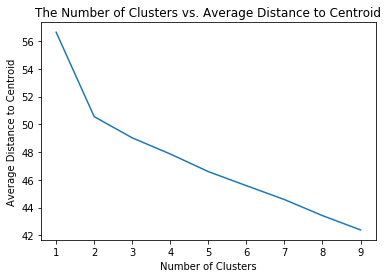

In [103]:
# plot the line graph between average distance and num_k to use the elbow method to find the optmial number of clusters
fig = plt.figure()
ax = plt.axes()

x = num_k
ax.plot(x, average_distance)
ax.set_title('The Number of Clusters vs. Average Distance to Centroid')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Distance to Centroid')

Using the "Elbow Method", it was determined the optimal number of clusters is two.

In [104]:
k_means = KMeans(init='k-means++', n_clusters=2, random_state=0, n_init=20).fit(neighborhood_grouped_clustering)
k_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [105]:
#create a dataframe which includes the cluster label
kmeansDataFrame = neighborhoods_venues_sorted
kmeansDataFrame.insert(0, 'Cluster Labels', k_means.labels_)

In [51]:
kMeansCluster1 = kmeansDataFrame.loc[kmeansDataFrame['Cluster Labels'] == 1]
kMeansCluster1.to_csv('kMeansCluster1.csv')

In [106]:
kMeansCluster1

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,1,Bayswater,Playground,Park,Tennis Court,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
55,1,Clason Point,Park,Pool,Moving Target,South American Restaurant,Boat or Ferry,Bus Stop,Home Service,Grocery Store,Factory,Field
221,1,Randall Manor,Park,Bus Stop,Playground,Yoga Studio,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
247,1,Somerville,Park,Yoga Studio,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
266,1,Todt Hill,Park,Yoga Studio,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
304,1,Bathurst Manor (34),Playground,Park,Baseball Field,Convenience Store,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market
307,1,Bayview Woods-Steeles (49),Park,Basketball Court,Dog Run,Zoo Exhibit,Egyptian Restaurant,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant
310,1,Bendale (127),Park,History Museum,Tennis Court,Greek Restaurant,Zoo Exhibit,Event Service,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
317,1,Brookhaven-Amesbury (30),Park,Zoo Exhibit,Dumpling Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant
319,1,Caledonia-Fairbank (109),Women's Store,Park,Zoo Exhibit,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space


In [148]:
neighborhood_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
2047,L'Amoreaux (117),43.795716,-79.314084,Coffee Time,43.797952,-79.318678,Coffee Shop
2048,L'Amoreaux (117),43.795716,-79.314084,Super Taste Noodle House,43.798217,-79.318513,Noodle House
2049,L'Amoreaux (117),43.795716,-79.314084,A Buck or Two,43.798286,-79.318485,Thrift / Vintage Store
2050,L'Amoreaux (117),43.795716,-79.314084,Olympian Swimming,43.791575,-79.313204,Gym Pool


In [456]:
#filter venues that are in cluster 1
filter1 = neighborhood_venues['Neighborhood'].isin(kMeansCluster1['Neighborhood'])
kmeansCluster1Count = neighborhood_venues[filter1].sort_values('Neighborhood')
kmeansCluster1Count

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1216,Bathurst Manor (34),43.764813,-79.456055,Irving W. Chapley Community Centre & Park,43.761247,-79.455509,Park
1215,Bathurst Manor (34),43.764813,-79.456055,Wilmington Park,43.761534,-79.456091,Playground
1214,Bathurst Manor (34),43.764813,-79.456055,Chapley Baseball Park,43.762100,-79.455866,Baseball Field
1213,Bathurst Manor (34),43.764813,-79.456055,Wilmington Convenience And Produce,43.764925,-79.455086,Convenience Store
9769,Bayswater,40.611322,-73.765968,Inwood Park,40.614236,-73.761475,Park
...,...,...,...,...,...,...,...
1048,Westminster-Branson (35),43.778813,-79.452418,Gym,43.781115,-79.450606,Gym / Fitness Center
1047,Westminster-Branson (35),43.778813,-79.452418,Got to half it Baby!,43.778242,-79.450862,Baby Store
1050,Westminster-Branson (35),43.778813,-79.452418,Dotch construction and renovation,43.781970,-79.453340,Construction & Landscaping
1095,Willowdale West (37),43.771210,-79.427558,Mobilicity,43.769937,-79.422369,Mobile Phone Shop


In [457]:
kmeansCluster1Count = kmeansCluster1Count.groupby('Venue Category').count()
kmeansCluster1Count.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
kmeansCluster1Count = kmeansCluster1Count.sort_values('Venue', ascending=False)

In [458]:
kmeansCluster1Count

,Venue
Venue Category,
Park,41
Playground,5
Pool,4
Moving Target,3
Tennis Court,3
Bus Stop,3
History Museum,3
Café,3
Construction & Landscaping,3


### DBSCAN

In [234]:
db = DBSCAN(eps=0.3, min_samples=7).fit(neighborhood_grouped_clustering)
labels = db.labels_

In [235]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

1

In [236]:
DbscanDataFrame = neighborhoods_venues_sorted
DbscanDataFrame

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Allerton,Pizza Place,Deli / Bodega,Bus Station,Cosmetics Shop,Chinese Restaurant,Supermarket,Department Store,American Restaurant,Dessert Shop,Gas Station
1,0,Annadale,Pizza Place,Restaurant,Bakery,Pharmacy,Liquor Store,Sports Bar,Diner,Train Station,American Restaurant,Dance Studio
2,0,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Home Service,Pizza Place,Yoga Studio,Field,Event Space,Exhibit
3,0,Arlington,Bus Stop,Intersection,Deli / Bodega,Grocery Store,Coffee Shop,Yoga Studio,Field,Event Space,Exhibit,Eye Doctor
4,0,Arrochar,Bus Stop,Bagel Shop,Deli / Bodega,Italian Restaurant,Supermarket,Taco Place,Middle Eastern Restaurant,Liquor Store,Outdoors & Recreation,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...,...
432,0,Wychwood (94),Event Space,Italian Restaurant,Farmers Market,Park,Coffee Shop,Zoo Exhibit,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service
433,0,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Gym,Movie Theater,Restaurant,Pizza Place,Shopping Mall,Food Court,Breakfast Spot,Buffet
434,0,Yonge-St.Clair (97),Coffee Shop,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Restaurant,Bank,Bagel Shop,Pub,Pizza Place,Sandwich Place
435,0,York University Heights (27),Massage Studio,Coffee Shop,Pizza Place,Fast Food Restaurant,Falafel Restaurant,Furniture / Home Store,Caribbean Restaurant,Bank,Japanese Restaurant,Bar


In [237]:
DbscanDataFrame.insert(0, 'Cluster Labels', db.labels_)

ValueError: cannot insert Cluster Labels, already exists

In [238]:
DbscanDataFrame['Cluster Labels'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### DBSCAN Cluster 0 Summary

In [466]:
dbscanCluster0 = dbscanCluster1 = DbscanDataFrame.loc[DbscanDataFrame['Cluster Labels']==0]
dbscanCluster0

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Allerton,Pizza Place,Deli / Bodega,Bus Station,Cosmetics Shop,Chinese Restaurant,Supermarket,Department Store,American Restaurant,Dessert Shop,Gas Station
1,0,Annadale,Pizza Place,Restaurant,Bakery,Pharmacy,Liquor Store,Sports Bar,Diner,Train Station,American Restaurant,Dance Studio
2,0,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Home Service,Pizza Place,Yoga Studio,Field,Event Space,Exhibit
3,0,Arlington,Bus Stop,Intersection,Deli / Bodega,Grocery Store,Coffee Shop,Yoga Studio,Field,Event Space,Exhibit,Eye Doctor
4,0,Arrochar,Bus Stop,Bagel Shop,Deli / Bodega,Italian Restaurant,Supermarket,Taco Place,Middle Eastern Restaurant,Liquor Store,Outdoors & Recreation,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...,...
432,0,Wychwood (94),Event Space,Italian Restaurant,Farmers Market,Park,Coffee Shop,Zoo Exhibit,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service
433,0,Yonge-Eglinton (100),Coffee Shop,Fast Food Restaurant,Gym,Movie Theater,Restaurant,Pizza Place,Shopping Mall,Food Court,Breakfast Spot,Buffet
434,0,Yonge-St.Clair (97),Coffee Shop,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Restaurant,Bank,Bagel Shop,Pub,Pizza Place,Sandwich Place
435,0,York University Heights (27),Massage Studio,Coffee Shop,Pizza Place,Fast Food Restaurant,Falafel Restaurant,Furniture / Home Store,Caribbean Restaurant,Bank,Japanese Restaurant,Bar


In [500]:
filter0 = neighborhood_venues['Neighborhood'].isin(dbscanCluster0['Neighborhood'])
dbscanCluster0Count = neighborhood_venues[filter0].sort_values('Neighborhood')
dbscanCluster0Count.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1126,Agincourt North (129),43.805441,-79.266712,Le Château,43.808635,-79.268297,Clothing Store
1134,Agincourt North (129),43.805441,-79.266712,Xe Lua Vietnamese Cuisine 火車頭,43.809224,-79.269547,Vietnamese Restaurant
1133,Agincourt North (129),43.805441,-79.266712,Bento Box,43.809248,-79.269029,Japanese Restaurant
1132,Agincourt North (129),43.805441,-79.266712,Everbest Bakery,43.808899,-79.269629,Bakery
1131,Agincourt North (129),43.805441,-79.266712,RBC Royal Bank,43.808757,-79.269280,Bank
1130,Agincourt North (129),43.805441,-79.266712,Smokers Corner Newstand,43.808624,-79.269437,Convenience Store
1129,Agincourt North (129),43.805441,-79.266712,Wild Wing,43.808799,-79.267808,Wings Joint
1128,Agincourt North (129),43.805441,-79.266712,LCBO,43.808126,-79.270046,Liquor Store
1127,Agincourt North (129),43.805441,-79.266712,Kin Kin Bubble Tea Co,43.807852,-79.270296,Chinese Restaurant
1135,Agincourt North (129),43.805441,-79.266712,McDonald's,43.808331,-79.267443,Fast Food Restaurant


In [501]:
#dbscanCluster0Count = dbscanCluster0Count.groupby('Venue Category').count()
#dbscanCluster0Count = dbscanCluster0Count.sort_values('Venue', ascending=False)
dbscanCluster0Count = dbscanCluster0Count.groupby('Venue Category').count()[['Venue']]
dbscanCluster0Count.sort_values('Venue', ascending=False, inplace=True)
dbscanCluster0Count.head(20)

,Venue
Venue Category,
Pizza Place,519
Coffee Shop,446
Italian Restaurant,355
Deli / Bodega,275
Bakery,254
Bar,245
Café,245
Sandwich Place,243
Grocery Store,240


#### DBSCAN Cluster 1 Summary

In [461]:
dbscanCluster1 = DbscanDataFrame.loc[DbscanDataFrame['Cluster Labels']==1]
dbscanCluster1

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,1,Bayswater,Playground,Park,Tennis Court,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
55,1,Clason Point,Park,Pool,Moving Target,South American Restaurant,Boat or Ferry,Bus Stop,Home Service,Grocery Store,Factory,Field
221,1,Randall Manor,Park,Bus Stop,Playground,Yoga Studio,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
247,1,Somerville,Park,Yoga Studio,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
266,1,Todt Hill,Park,Yoga Studio,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
304,1,Bathurst Manor (34),Playground,Park,Baseball Field,Convenience Store,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market
307,1,Bayview Woods-Steeles (49),Park,Basketball Court,Dog Run,Zoo Exhibit,Egyptian Restaurant,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant
310,1,Bendale (127),Park,History Museum,Tennis Court,Greek Restaurant,Zoo Exhibit,Event Service,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
317,1,Brookhaven-Amesbury (30),Park,Zoo Exhibit,Dumpling Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant
319,1,Caledonia-Fairbank (109),Women's Store,Park,Zoo Exhibit,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space


In [66]:
dbscanCluster1

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,1,Bayswater,Playground,Park,Tennis Court,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
55,1,Clason Point,Park,Pool,Moving Target,South American Restaurant,Boat or Ferry,Bus Stop,Home Service,Grocery Store,Factory,Field
221,1,Randall Manor,Park,Bus Stop,Playground,Yoga Studio,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
247,1,Somerville,Park,Yoga Studio,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
266,1,Todt Hill,Park,Yoga Studio,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
304,1,Bathurst Manor (34),Playground,Park,Baseball Field,Convenience Store,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market
307,1,Bayview Woods-Steeles (49),Park,Basketball Court,Dog Run,Zoo Exhibit,Egyptian Restaurant,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant
310,1,Bendale (127),Park,History Museum,Tennis Court,Greek Restaurant,Zoo Exhibit,Event Service,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
317,1,Brookhaven-Amesbury (30),Park,Zoo Exhibit,Dumpling Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant
319,1,Caledonia-Fairbank (109),Women's Store,Park,Zoo Exhibit,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space


In [231]:
filter1 = neighborhood_venues['Neighborhood'].isin(dbscanCluster1['Neighborhood'])
dbscanCluster1Count = neighborhood_venues[filter1].sort_values('Neighborhood')
dbscanCluster1Count

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1216,Bathurst Manor (34),43.764813,-79.456055,Irving W. Chapley Community Centre & Park,43.761247,-79.455509,Park
1215,Bathurst Manor (34),43.764813,-79.456055,Wilmington Park,43.761534,-79.456091,Playground
1214,Bathurst Manor (34),43.764813,-79.456055,Chapley Baseball Park,43.762100,-79.455866,Baseball Field
1213,Bathurst Manor (34),43.764813,-79.456055,Wilmington Convenience And Produce,43.764925,-79.455086,Convenience Store
9769,Bayswater,40.611322,-73.765968,Inwood Park,40.614236,-73.761475,Park
...,...,...,...,...,...,...,...
1048,Westminster-Branson (35),43.778813,-79.452418,Gym,43.781115,-79.450606,Gym / Fitness Center
1047,Westminster-Branson (35),43.778813,-79.452418,Got to half it Baby!,43.778242,-79.450862,Baby Store
1050,Westminster-Branson (35),43.778813,-79.452418,Dotch construction and renovation,43.781970,-79.453340,Construction & Landscaping
1095,Willowdale West (37),43.771210,-79.427558,Mobilicity,43.769937,-79.422369,Mobile Phone Shop


In [232]:
dbscanCluster1Count = dbscanCluster1Count.groupby('Venue Category').count()[['Venue']]
dbscanCluster1Count.sort_values('Venue', ascending=False, inplace=True)
dbscanCluster1Count

In [233]:
dbscanCluster1Count.head(10)

,Venue
Venue Category,
Park,41
Playground,5
Pool,4
Moving Target,3
Tennis Court,3
Bus Stop,3
History Museum,3
Café,3
Construction & Landscaping,3
